<a href="https://colab.research.google.com/github/diane-park/TableSnap/blob/main/TableSnap_Final_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TableSnap Final Submission

This notebook contains the entire code to perform table detection on images of digital documents. This is step 1 in being able to create a way to turn hand-filled tables into csv files.

This notebook is split into _ parts:


1.   Downloading Dataset
2.   Data Preprocessing
3.   Baseline Model (YOLOv5s)
4.   Fine Tuning
5.   Evaluation
2.   Visualization








## Downloading Dataset

The dataset that we are using is the [General Table Detection Dataset](https://www.kaggle.com/datasets/rhtsingh/general-table-recognition-dataset/data?select=train.csv).
 This dataset contains scanned documents including one or more tables and comes with corresponding table annotations which give bounding box coordinates of the table within the image. This dataset will be downloaded off of Kaggle.

### Installing Dependencies

Creating a requirements.txt file will help ensure consistency when running this code from another machine.

In [ ]:
# Create a requirements.txt file
requirements = """
kagglehub
pandas==1.5.3
torch==2.7.0+cu126
opencv-python==4.5.3.56
matplotlib==3.5.1
git+https://github.com/ultralytics/yolov5.git
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

# Install dependencies
!pip install -U -r requirements.txt

  Cloning https://github.com/ultralytics/yolov5.git to /tmp/pip-req-build-zbd1qiun
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5.git /tmp/pip-req-build-zbd1qiun
  Resolved https://github.com/ultralytics/yolov5.git to commit a493afe1486639b6f542c69716d131bd103ceeef
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


## Download from KaggleHub


In [51]:
# necessary imorts
import kagglehub
import os
import shutil
%matplotlib inline

In [ ]:
# Download latest version of dataset
path = kagglehub.dataset_download("rhtsingh/general-table-recognition-dataset")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /kaggle/input/general-table-recognition-dataset


['train_folds.csv',
 'Orig_Annotations-20220104T075522Z-001',
 'create_folds.py',
 'Orig_Image-20220104T074306Z-001',
 'train_annotated.csv',
 'General Dataset-20220104T073035Z-001',
 'train.csv']

### Data Cleansing

As part of our data cleansing, we will first pull relevant information about the informations from the annotation and folds csv files that come with the dataset.

In [ ]:
import pandas as pd

annotations_file_path = path + '/train_annotated.csv'
folds_file_path = path + '/train_folds.csv'

# Pull information from annotations and folds csv files
annotations = pd.read_csv(annotations_file_path)
folds = pd.read_csv(folds_file_path)

# Print first 5 lines of each file
print(annotations.head())
print(folds.head())

   image_id                    bbox  \
0  0101_003  [769, 945, 1301, 2028]   
1  0110_099  [269, 1652, 2022, 980]   
2  0113_013                     NaN   
3  0140_007  [698, 1781, 1083, 290]   
4  0146_281  [703, 431, 1041, 1121]   

                                       segmentation       area  height  \
0    [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1  [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
2                                               NaN        NaN     NaN   
3  [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
4    [[703, 431, 703, 1552, 1744, 1552, 1744, 431]]  1166961.0  3300.0   

    width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0  2544.0      769.0      945.0      1301.0       2028.0  
1  2544.0      269.0     1652.0      2022.0        980.0  
2     NaN        NaN        NaN         NaN          NaN  
3  2560.0      698.0     1781.0      1083.0        290.0  
4  2544.0      703.0     

In [ ]:
# continuing filtering for single datatables using annotated dataset
# only need annotations_filtered now, don't need to use folds
valid_image_ids = set(folds["image_id"])

annotations_filtered = annotations[annotations["image_id"].isin(valid_image_ids)].copy()

print(annotations_filtered.head())
print(annotations_filtered.shape)

   image_id                    bbox  \
0  0101_003  [769, 945, 1301, 2028]   
1  0110_099  [269, 1652, 2022, 980]   
3  0140_007  [698, 1781, 1083, 290]   
4  0146_281  [703, 431, 1041, 1121]   
5  0146_281  [704, 1745, 1096, 695]   

                                       segmentation       area  height  \
0    [[769, 945, 769, 2973, 2070, 2973, 2070, 945]]  2638428.0  3300.0   
1  [[269, 1652, 269, 2632, 2291, 2632, 2291, 1652]]  1981560.0  3300.0   
3  [[698, 1781, 698, 2071, 1781, 2071, 1781, 1781]]   314070.0  3300.0   
4    [[703, 431, 703, 1552, 1744, 1552, 1744, 431]]  1166961.0  3300.0   
5  [[704, 1745, 704, 2440, 1800, 2440, 1800, 1745]]   761720.0  3300.0   

    width  bbox_xmin  bbox_ymin  bbox_width  bbox_height  
0  2544.0      769.0      945.0      1301.0       2028.0  
1  2544.0      269.0     1652.0      2022.0        980.0  
3  2560.0      698.0     1781.0      1083.0        290.0  
4  2544.0      703.0      431.0      1041.0       1121.0  
5  2544.0      704.0     

In [ ]:
# Rescale bbox values to be in terms of the image width and height instead of pixel value
# This will lead to less issues when resizing images during the data loading

scaled_bboxes = []
for index, row in annotations_filtered.iterrows():
  x_min = row['bbox_xmin']
  y_min = row['bbox_ymin']
  bbox_width = row['bbox_width']
  bbox_height = row['bbox_height']

  im_width= row["width"]
  im_height = row["height"]

  # All bbox values are now from 0 to 1
  bbox = [x_min/im_width, y_min/im_height, bbox_width/im_width, bbox_height/im_height]

  scaled_bboxes.append(bbox)

In [ ]:
# Declare X and Y variables
X = annotations_filtered["image_id"].to_list()
Y = scaled_bboxes

# Check we have the same number of inputs and labels
print("Number of samples in X: ", len(X))
print("Number of samples in Y: ", len(Y))

Number of samples in X:  2835
Number of samples in Y:  2835


## Data Processing
Create 70/20/10 train/val/test splits

In [ ]:
# Total number of samples
total_samples = len(X)

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Calculate the indices for splitting
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)
test_size = int(total_samples * test_ratio)

# Split the data dynamically
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print("Number of samples in train set: ", len(X_train))
print("Number of samples in val set: ", len(X_val))
print("Number of samples in test set: ", len(X_test))

Number of samples in train set:  1984
Number of samples in val set:  567
Number of samples in test set:  284


In [ ]:
# Target YOLO-style structure
target_train_image_dir = 'dataset/images/train'
target_train_label_dir = 'dataset/labels/train'

target_val_image_dir = 'dataset/images/val'
target_val_label_dir = 'dataset/labels/val'

target_test_image_dir = 'dataset/images/test'
target_test_label_dir = 'dataset/labels/test'


# create the directories to write to later
os.makedirs(target_train_image_dir, exist_ok=True)
os.makedirs(target_train_label_dir, exist_ok=True)
os.makedirs(target_val_image_dir, exist_ok=True)
os.makedirs(target_val_label_dir, exist_ok=True)
os.makedirs(target_test_image_dir, exist_ok=True)
os.makedirs(target_test_label_dir, exist_ok=True)

In [ ]:
def process_data(ids, bboxes, target_image_dir, target_label_dir):
    for id, bbox in zip(ids, bboxes):
        # Determine which image file to copy (PNG or JPG)
        if os.path.exists(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/'  + id + '.png'):
            shutil.copy(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/'  + id + '.png', target_image_dir + '/' + id + '.png')
        else:
            shutil.copy(path + '/Orig_Image-20220104T074306Z-001/Orig_Image/'  + id + '.jpg', target_image_dir + '/' + id + '.jpg')

        # Create label file
        new_file = target_label_dir + '/' + id + '.txt'

        # Calculate bounding box in YOLO format (x_center, y_center, width, height)
        x_center = bbox[0] + bbox[2]/2
        y_center = bbox[1] + bbox[3]/2
        width = bbox[2]
        height = bbox[3]

        # Write the label file
        with open(new_file, "w") as file:
            file.write(f"0 {x_center} {y_center} {width} {height}")

# TEST
process_data(X_test, Y_test, target_test_image_dir, target_test_label_dir)

# VALIDATION
process_data(X_val, Y_val, target_val_image_dir, target_val_label_dir)

# TRAIN
process_data(X_train, Y_train, target_train_image_dir, target_train_label_dir)

## Baseline Model

We will use YOLOv5 as our baseline model for obejct detection. We thought YOLO would be a good baseline because it pads images for you and resizes them so we can have images of different sizes.

In [ ]:
# Clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

# Install dependencies
!pip install -U -r requirements.txt

import torch
print(torch.cuda.is_available())  # Should print True if GPU is available

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
True


In [ ]:
# Create data.yaml file

data_yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val
test: /content/dataset/images/test

nc: 1
names: ['datatables']
"""

# Specify the path where to save the data.yaml file
data_yaml_path = '/content/data.yaml'

# Write the content to the data.yaml file
with open(data_yaml_path, 'w') as file:
    file.write(data_yaml_content)

print(f"data.yaml file created at {data_yaml_path}")

data.yaml file created at /content/data.yaml


You will have the option to enter your W&B account in order to visualize results. Please input your account info, if possible.

Please use a GPU to accelerate the training. In Colab, you can enable this in **Runtime** -> **Change Runtime Type** -> Under **Hardware accelerator**, select **GPU** -> Save


## ONLY RUN THE FOLLOWING TWO CELLS IF YOU WANT TO RETRAIN FROM SCRATCH

In [14]:
# train from the YOLOv5 repo
!python train.py --img 640 --batch 16 --epochs 10 --exist-ok --data /content/data.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --name yolo_model > train.log 2>&1


In [15]:
# Save weights to Shared Google Drive after training
from google.colab import drive
drive.mount('/content/drive')

# Create a folder for the model weights
!mkdir -p "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models"

# Copy the trained weights to Drive
!cp runs/train/yolo_model/weights/best.pt "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_all_tables_best.pt"

Mounted at /content/drive


### Evaluation of Baseline Model

Model is evaluated on the test set and precision and recall are calculated. From those values we then calculate the F1 score as well.

A visual precision-recall curve is also auto generated by YOLO evaluation.

You will have to change model_weights variable to wherever you saved the weights file to.

In [17]:
# Define paths
test_image_dir = 'dataset/images/test'
test_label_dir = 'dataset/labels/test'
# model_weights = 'runs/train/yolo_model/weights/best.pt'
model_weights = "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_all_tables_best.pt"

# Load the trained YOLOv5 model (optional, for manual inference or visualizations)
import torch
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights, trust_repo=True)

# Run YOLOv5's evaluation script on the test set
!python val.py --weights "{model_weights}" --data /content/data.yaml --task test --img 640 --save-json --iou-thres 0.9


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


YOLOv5 🚀 2025-5-17 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


val: data=/content/data.yaml, weights=['/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/baseline_yolo_all_tables_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.9, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/dataset/labels/test... 176 images, 0 backgrounds, 0 corrupt: 100% 176/176 [00:00<00:00, 1461.15it/s]
test: New cache created: /content/dataset/labels/test.cache
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 6/6 [00:07<00:00,  1.25s/it]
                   all        176        176      0.744      0.784      0

In [18]:
# Calculate F1 score
precision = 0.744
recall = 0.784

f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Output
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

Precision: 0.7440
Recall:    0.7840
F1 Score:  0.7635


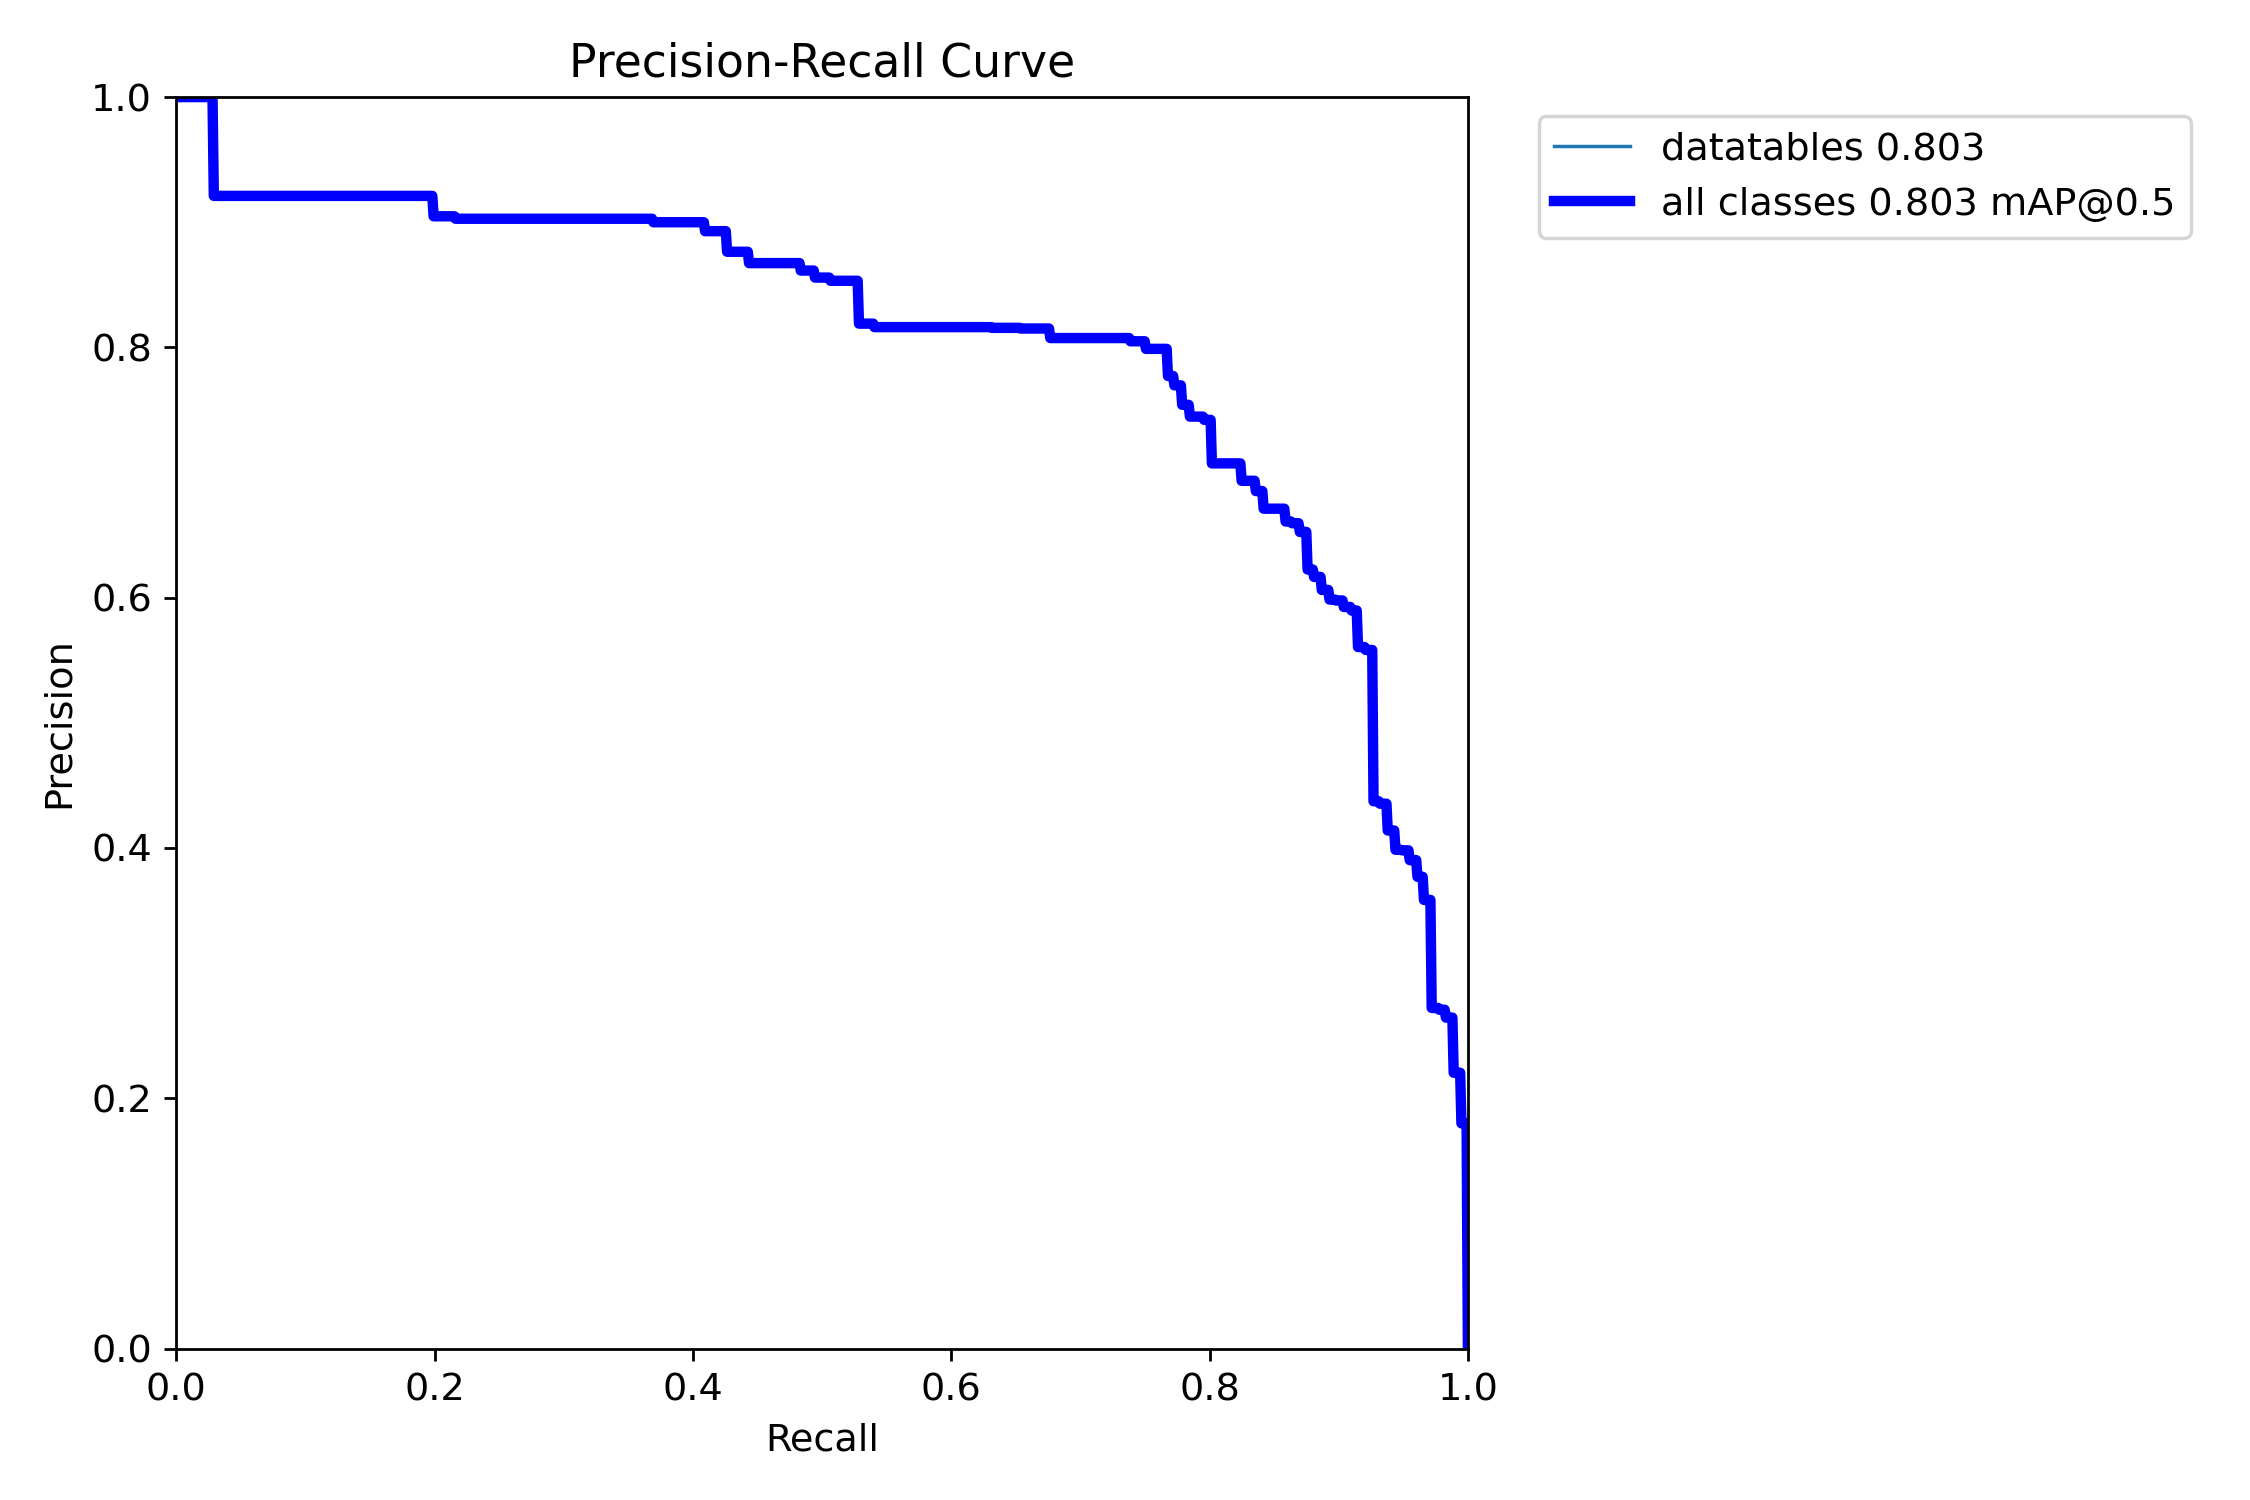

In [20]:
from IPython import display
display.Image("/content/yolov5/runs/val/exp/PR_curve.png", width=600)


#Deep Learning Model


## ONLY RUN THE NEXT TWO CELLS IF YOU WANT TO RETRAIN FROM SCRATCH

In [22]:
# go to the YOLOv5 repo
%cd yolov5

# fine-tune from our baseline model with more epochs, and a lower learning rate
!python train.py --img 640 --batch 16 --epochs 30 --exist-ok --data /content/data.yaml --cfg models/yolov5s.yaml --weights runs/train/yolo_model/weights/best.pt --name fine_tuned_model --hyp data/hyps/hyp.scratch-low.yaml > train.log 2>&1


[Errno 2] No such file or directory: 'yolov5'
/content/yolov5


In [24]:
# Save weights to Google Drive after training
# Copy the trained weights to Drive
!cp runs/train/fine_tuned_model/weights/best.pt "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_all_tables_best.pt"

### Evaluation of Fine-tuned Model

Model is evaluated on the test set and precision and recall are calculated. From those values we then calculate the F1 score as well.

A visual precision-recall curve is also auto generated by YOLO evaluation.

You will have to change the model_weights variable to wherever you saved the file to

In [27]:
# Define paths
test_image_dir = 'dataset/images/test'
test_label_dir = 'dataset/labels/test'
model_weights = "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_all_tables_best.pt"

import torch

# Load the trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_weights, trust_repo=True)

# evaluate model with test images
!python val.py --weights "{model_weights}" --data /content/data.yaml --task test --img 640 --save-json --iou-thres 0.9

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-17 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


val: data=/content/data.yaml, weights=['/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_all_tables_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.9, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-418-ga493afe1 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/dataset/labels/test.cache... 176 images, 0 backgrounds, 0 corrupt: 100% 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 6/6 [00:05<00:00,  1.01it/s]
                   all        176        176      0.871      0.881      0.913      0.832
Speed: 1.5ms pre-process, 6.8ms inference, 4.8ms NM

In [28]:
# Calculate F1 score
precision = 0.871
recall = 0.881
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Output
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1_score:.4f}")

Precision: 0.8710
Recall:    0.8810
F1 Score:  0.8760


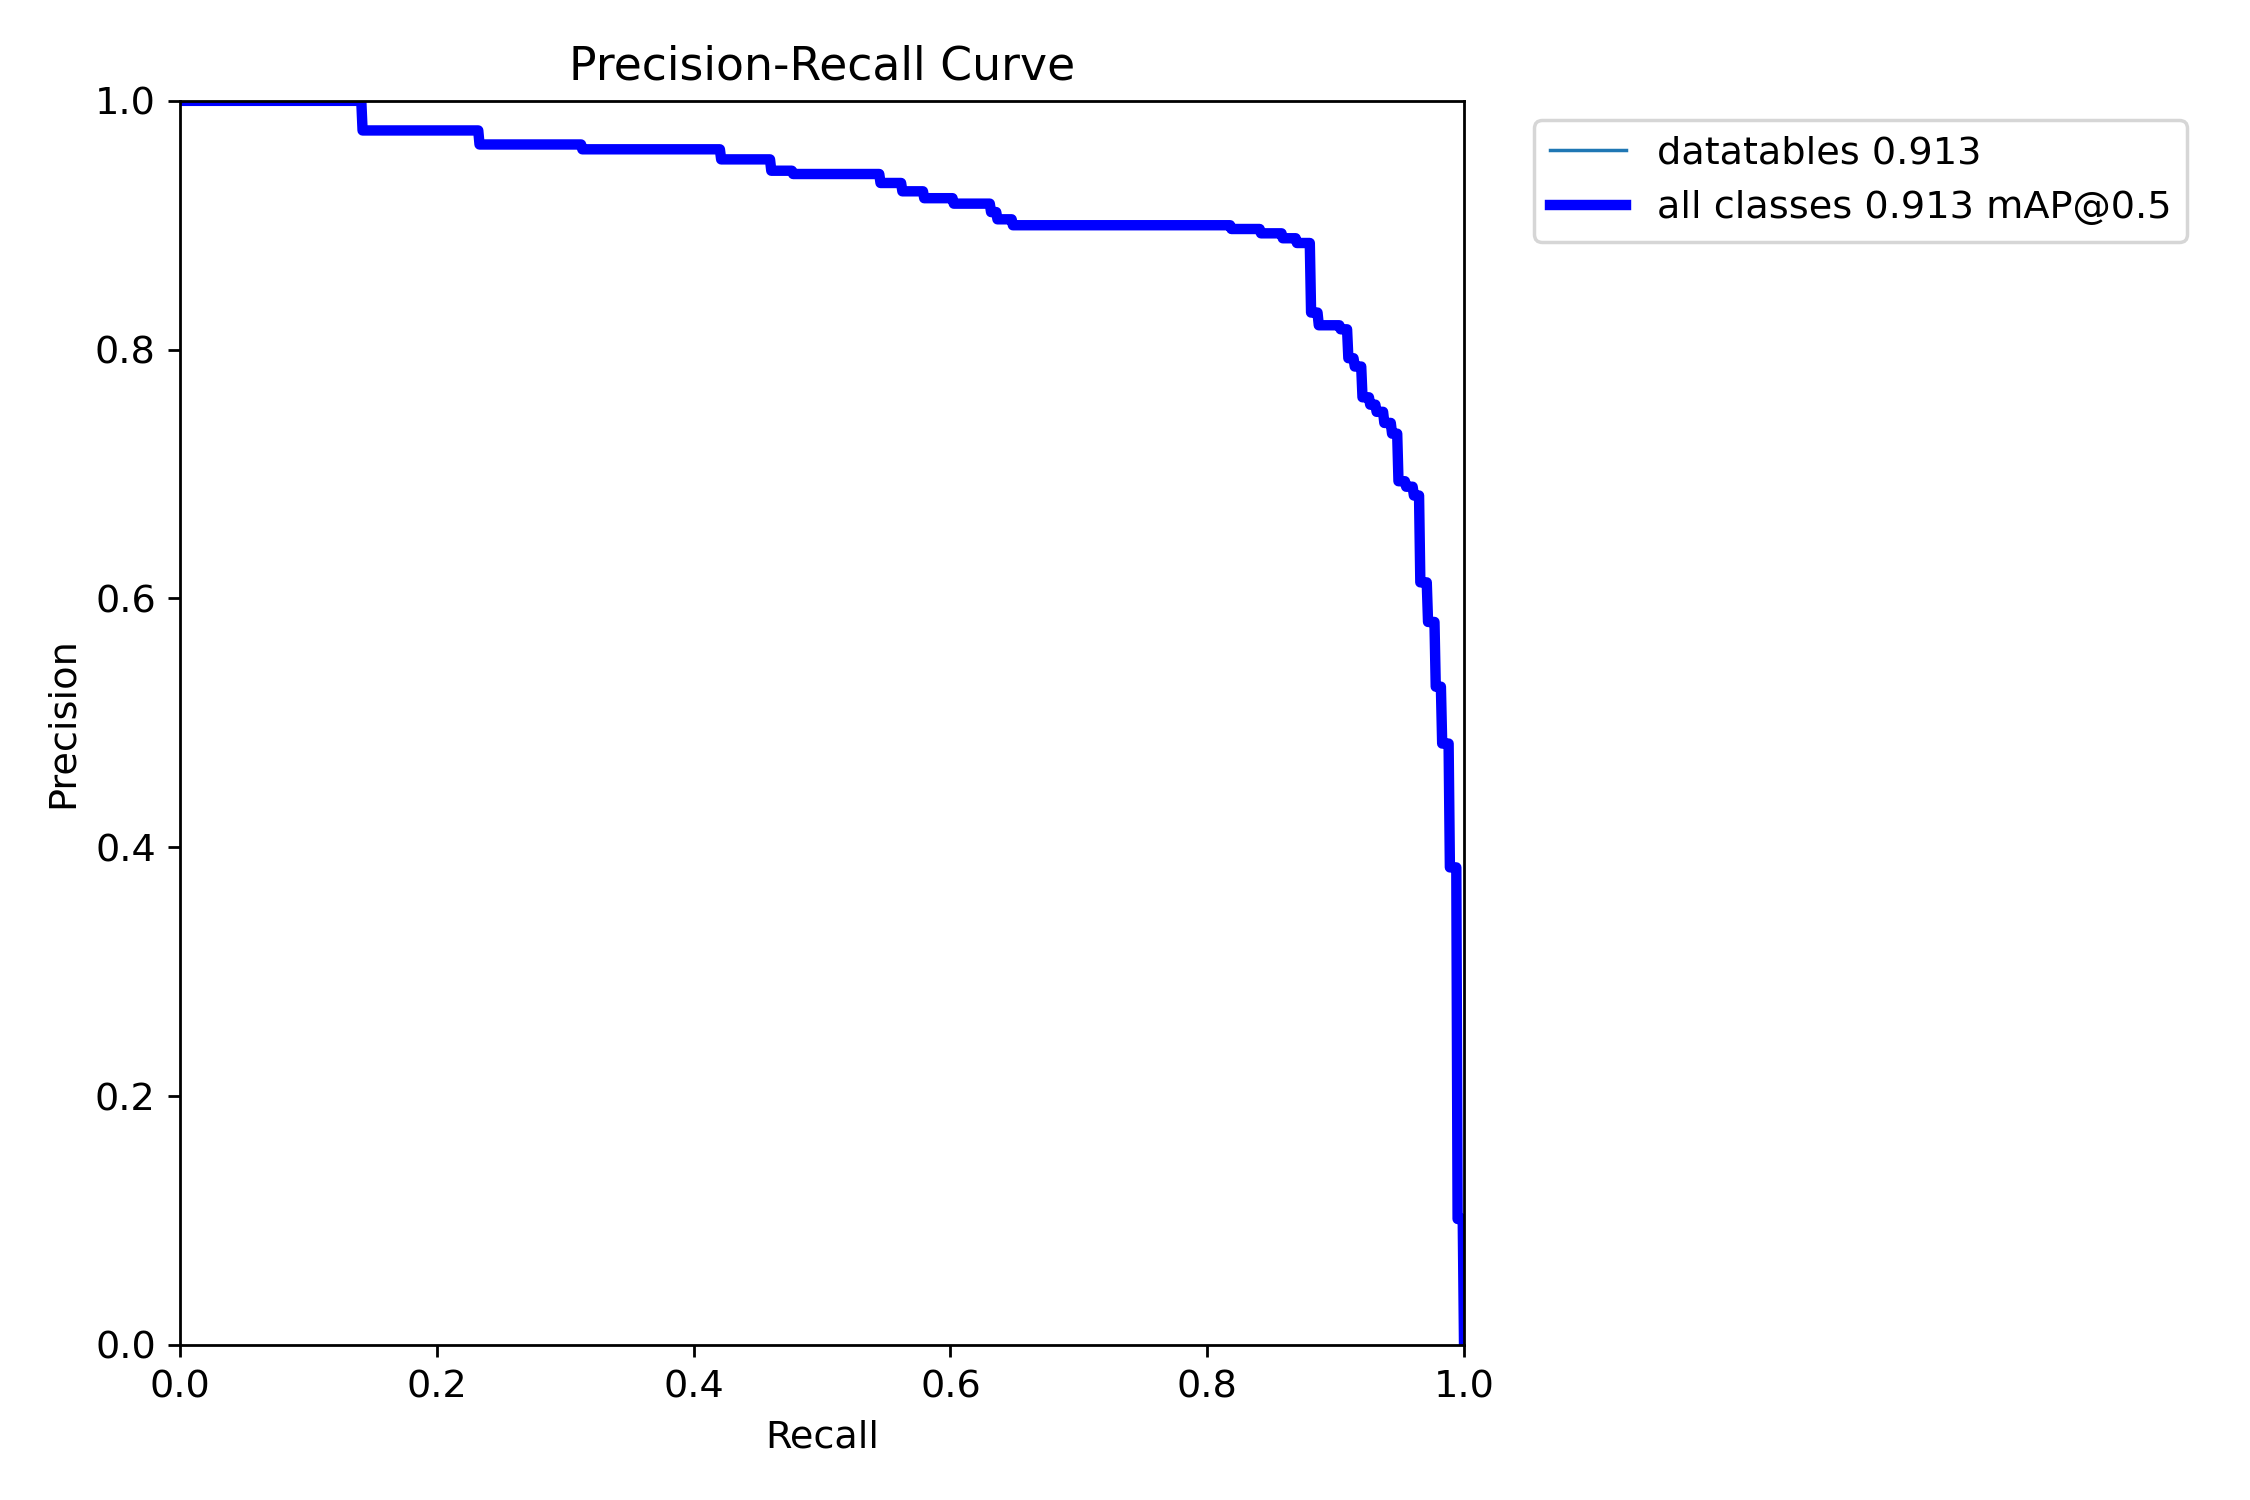

In [29]:
display.Image("/content/yolov5/runs/val/exp2/PR_curve.png", width=600)

## Visualization of Predictions

In this section, you will randomly chose 2 images from the test set, generate predictions, then visualize bounding boxes.

In [87]:
import random

# Choose a random image from the test set
test_image_dir = '/content/dataset/images/test'
img_filename1 = random.choice(os.listdir(test_image_dir))
img_path1 = os.path.join(test_image_dir, img_filename1)
print(f"Selected image: {img_path1}")


test_image_dir = '/content/dataset/images/test'
img_filename2 = random.choice(os.listdir(test_image_dir))
img_path2 = os.path.join(test_image_dir, img_filename2)
print(f"Selected image: {img_path2}")


Selected image: /content/dataset/images/test/cTDaR_t10429.jpg
Selected image: /content/dataset/images/test/cTDaR_t10558.jpg


In [31]:
finetuned_weights = "/content/drive/Shared drives/Deep Learning/Deep Learning CSV/yolov5_models/fine_tuned_all_tables_best.pt"

# Load models
finetuned_model = torch.hub.load('ultralytics/yolov5', 'custom', path=finetuned_weights, trust_repo=True)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-17 Python-3.11.12 torch-2.7.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


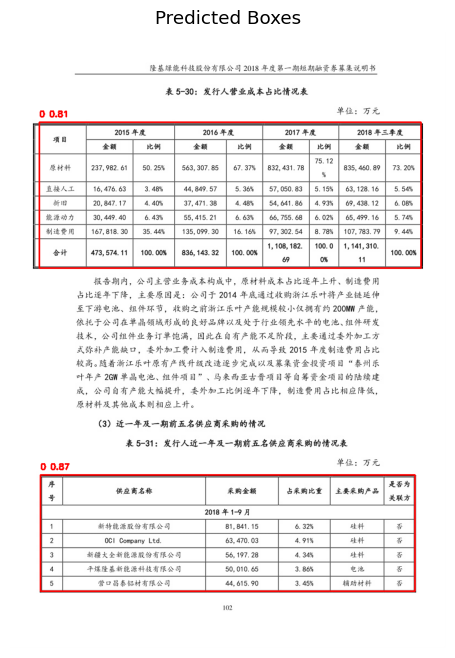

/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


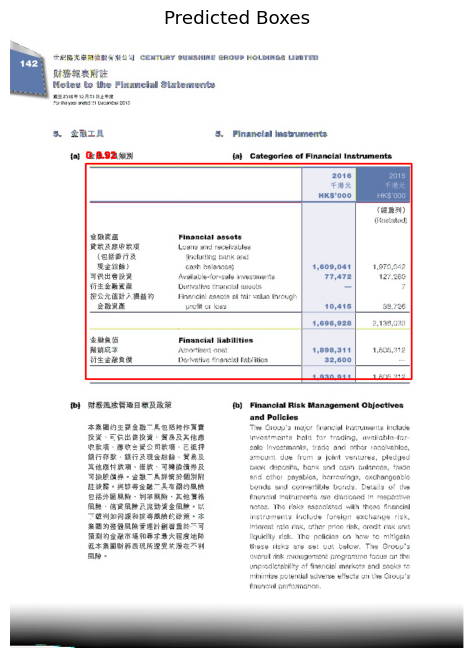

In [89]:
import matplotlib.pyplot as plt
import cv2

plt.close('all')

img1 = cv2.imread(img_path1)
results = finetuned_model(img_path1)

for *box, conf, cls in results.xyxy[0].cpu().numpy():
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red box
    cv2.putText(img1, f'{int(cls)} {conf:.2f}', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicted Boxes")
plt.show()

img2 = cv2.imread(img_path2)
results = finetuned_model(img_path2)

for *box, conf, cls in results.xyxy[0].cpu().numpy():
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img2, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red box
    cv2.putText(img2, f'{int(cls)} {conf:.2f}', (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)


plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predicted Boxes")
plt.show()